# Interpolation to query points

In this example we show how to interpolate to an arbitrary set of query points.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynek

In [2]:
from pynektools.io.ppymech.neksuite import pynekread
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

In [3]:
msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
fname = '../data/rbc0.f00001'
pynekread(fname, comm, data_dtype=np.double, msh=msh, fld=fld)

2024-09-11 18:27:03,861 - Mesh - INFO - Initializing empty Mesh object.
2024-09-11 18:27:03,863 - Field - INFO - Initializing empty Field object
2024-09-11 18:27:03,864 - pynekread - INFO - Reading file: ../data/rbc0.f00001
2024-09-11 18:27:03,876 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-09-11 18:27:03,876 - Mesh - INFO - Initializing common attributes.
2024-09-11 18:27:03,877 - Mesh - INFO - Getting vertices
2024-09-11 18:27:03,878 - Mesh - INFO - Getting vertices
2024-09-11 18:27:03,888 - Mesh - INFO - Getting facet centers
2024-09-11 18:27:03,896 - Mesh - INFO - Creating connectivity
2024-09-11 18:27:04,376 - Mesh - INFO - Mesh object initialized.
2024-09-11 18:27:04,377 - Mesh - INFO - Mesh data is of type: float64
2024-09-11 18:27:04,378 - Mesh - INFO - Elapsed time: 0.502331771s
2024-09-11 18:27:04,378 - pynekread - INFO - Reading field data
2024-09-11 18:27:04,389 - pynekread - INFO - File read
2024-09-11 18:27:04,389 - pynekread - INFO - Elapsed time: 

## Building the set of points to use

In this case, we will use a cylindrical mesh to interpolate the points in our domain.

For this, we will use some tools to generate point distributions.

Be mindful that in general, the interpolation routines will only takei nto considerations the points that are passed in rank 0.

For this reason, we build all the points only in this rank and generate a dummy variable xyz in other ranks.

In [4]:
# Import helper functions
import pynektools.interpolation.utils as interp_utils
import pynektools.interpolation.pointclouds as pcs


if comm.Get_rank() == 0 :
    # Generate the bounding box of the points
    x_bbox = [0, 0.05]
    y_bbox = [0, 2*np.pi]
    z_bbox = [0 , 1]
    nx = 30
    ny = 30
    nz = 80
    
    # Generate the 1D mesh
    x_1d = pcs.generate_1d_arrays(x_bbox, nx, mode="equal")
    y_1d = pcs.generate_1d_arrays(y_bbox, ny, mode="equal")
    z_1d = pcs.generate_1d_arrays(z_bbox, nz, mode="equal")

    # Generate a 3D mesh
    r, th, z = np.meshgrid(x_1d, y_1d, z_1d, indexing='ij')
    x = r*np.cos(th)
    y = r*np.sin(th)

    # Array the points as a list of probes
    xyz = interp_utils.transform_from_array_to_list(nx,ny,nz,[x, y, z])

    # Write the points for future use
    with open('points.csv', 'w') as f:
        for i in range((xyz.shape[0])):
            f.write(f"{xyz[i][0]},{xyz[i][1]},{xyz[i][2]}\n")
else:
    xyz = 1


## Interpolate

The module to use for the interpolations is:

In [5]:
from pynektools.interpolation.probes import Probes

### Interpolate from points in memory

We have created the xyz points and we have them in memory, so we can just interpolate form there.

#### Finding the points

The first step is to initialize the probe object, which will attempt to find the query points in the SEM mesh.

There are many options to do this, so we recommend that you check the documentation for this class.

In [6]:
probes = Probes(comm, probes = xyz, msh = msh, point_interpolator_type='multiple_point_legendre_numpy', max_pts=256, find_points_comm_pattern='point_to_point')

2024-09-11 18:27:05,085 - Probes - INFO - Initializing Probes object
2024-09-11 18:27:05,087 - Probes - INFO - Probes provided as keyword argument
2024-09-11 18:27:05,089 - Probes - INFO - Input probes are distributed: False
2024-09-11 18:27:05,090 - Probes - INFO - Mesh provided as keyword argument
2024-09-11 18:27:05,096 - Probes - INFO - Initializing interpolator
2024-09-11 18:27:05,098 - Interpolator - INFO - Initializing Interpolator object
2024-09-11 18:27:05,105 - Interpolator - INFO - Initializing point interpolator: multiple_point_legendre_numpy
2024-09-11 18:27:05,118 - Interpolator - INFO - Allocating buffers in point interpolator
2024-09-11 18:27:05,121 - Interpolator - INFO - Using device: cpu
2024-09-11 18:27:05,126 - Interpolator - INFO - Interpolator initialized
2024-09-11 18:27:05,127 - Interpolator - INFO - Elapsed time: 0.02208092599999989s
2024-09-11 18:27:05,128 - Probes - INFO - Setting up global tree
2024-09-11 18:27:05,129 - Interpolator - INFO - Using global_tr

### Interpolate a set of fields

To interpolate a particular field, you must call the function and put the fields in a list, as follow:

In [7]:
# The first input is the time to write in the file
probes.interpolate_from_field_list(0, [fld.registry['w']], comm, write_data=False)

2024-09-11 18:27:26,237 - Probes - INFO - Interpolating fields from field list
2024-09-11 18:27:26,239 - Probes - INFO - Interpolating field 0
2024-09-11 18:27:26,239 - Interpolator - INFO - Interpolating field from rst coordinates
2024-09-11 18:27:26,660 - Interpolator - INFO - Elapsed time: 0.42095929099999907s


### Plot results

The points have now been interpolated and are gathered once again in rank 0. Therefore one can proceed to perform operations such as plotting.

Note that they are still arrayed as a list. If one whishes to use the structured mesh format, then the points must be mapped back to their original shape.

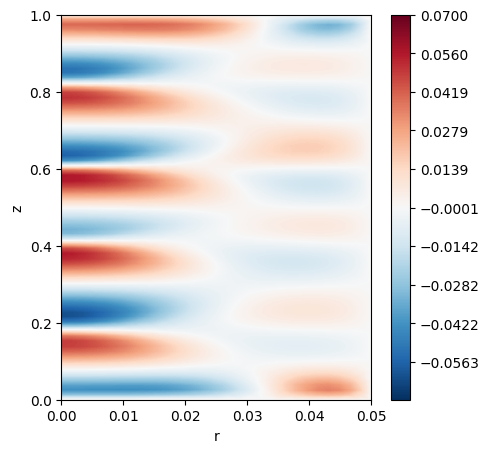

In [8]:
if comm.Get_rank() == 0:

    polar_fields = interp_utils.transform_from_list_to_array(nx,ny,nz,probes.interpolated_fields)
    w_polar = polar_fields[1]

    w_2d = np.mean(w_polar, axis=1)

    levels = 500
    levels = np.linspace(-0.07, 0.07, levels)
    cmapp='RdBu_r'
    fig, ax = plt.subplots(1, 1,figsize=(5, 5))

    c1 = ax.tricontourf(r[:,0,:].flatten(), z[:,0,:].flatten() ,w_2d.flatten(), levels=levels, cmap=cmapp)
    fig.colorbar(c1)
    ax.set_xlabel("r")
    ax.set_ylabel("z")
    plt.show()

### Interpolate to points in a csv

If the points are already in a csv file, we can choose to interpolate from those, instead of bulding points in memory (which we already did).

One option is to of course read them and assign them to the xyz array we indicated before. The same can be done with the mesh.

Simply write the path to the file where the mesh and/or the probes are in the appropiate keyword argument.

#### Initializing the probes object

Now we can initialize the probes object

In [9]:
probes2 = Probes(comm, probes="./points.csv", msh = '../data/rbc0.f00001', point_interpolator_type='multiple_point_legendre_numpy', max_pts=256, find_points_comm_pattern='point_to_point')

2024-09-11 18:27:27,207 - Probes - INFO - Initializing Probes object
2024-09-11 18:27:27,208 - Probes - INFO - Reading probes from ./points.csv
2024-09-11 18:27:27,388 - Probes - INFO - Input probes are distributed: False
2024-09-11 18:27:27,388 - Probes - INFO - Reading mesh from ../data/rbc0.f00001
2024-09-11 18:27:27,389 - Mesh - INFO - Initializing empty Mesh object.
2024-09-11 18:27:27,390 - pynekread - INFO - Reading file: ../data/rbc0.f00001
2024-09-11 18:27:27,393 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-09-11 18:27:27,394 - Mesh - INFO - Initializing common attributes.
2024-09-11 18:27:27,394 - Mesh - INFO - Getting vertices
2024-09-11 18:27:27,395 - Mesh - INFO - Getting vertices
2024-09-11 18:27:27,403 - Mesh - INFO - Getting facet centers
2024-09-11 18:27:27,409 - Mesh - INFO - Mesh object initialized.
2024-09-11 18:27:27,410 - Mesh - INFO - Mesh data is of type: float32
2024-09-11 18:27:27,410 - Mesh - INFO - Elapsed time: 0.016976128999999673s
20

After this, you can simply follow the same steps to interpolate fields. You can write the fields to the same data type by using the appropiate command.


In [10]:
probes2.interpolate_from_field_list(0, [fld.registry['w']], comm, write_data=True)

2024-09-11 18:27:46,242 - Probes - INFO - Interpolating fields from field list
2024-09-11 18:27:46,244 - Probes - INFO - Interpolating field 0
2024-09-11 18:27:46,245 - Interpolator - INFO - Interpolating field from rst coordinates
2024-09-11 18:27:46,703 - Interpolator - INFO - Elapsed time: 0.4582567080000004s
2024-09-11 18:27:46,706 - Probes - INFO - Writing interpolated fields to ./interpolated_fields.csv


## Reading probes results from CSV

To read probes, we can use the probe reader object. Note that we will do this in rank 0. This is also the format of Neko probes, therefore you will be able to read those too.

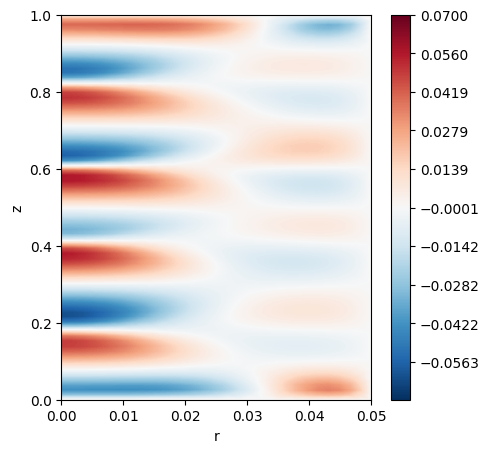

In [11]:
# Import the module
from pynektools.io.read_probes import ProbesReader

if comm.Get_rank() == 0:

    pr = ProbesReader(file_name = './interpolated_fields.csv')

    # The name of the field is the index in the list when interpolated by default
    w_polar2 = interp_utils.transform_from_list_to_array(nx,ny,nz,pr.fields['0'])
 
    w_2d2 = np.mean(w_polar2[0], axis=1)

    levels = 500
    levels = np.linspace(-0.07, 0.07, levels)

    cmapp='RdBu_r'
    fig, ax = plt.subplots(1, 1,figsize=(5, 5))

    c1 = ax.tricontourf(r[:,0,:].flatten(), z[:,0,:].flatten() ,w_2d2.flatten(), levels=levels, cmap=cmapp)
    fig.colorbar(c1)
    ax.set_xlabel("r")
    ax.set_ylabel("z")
    plt.show()